1. Linux is still shit, as in, things never seems to work out of the box and you have to spend hours to get things to work.
2. Every single time I want to use tensorflow, I need to activate the tf environment and otherwise, GPU is not available. Hopefully, I don't forget to do that by typing 'conda activate tf' in the terminal.
3. Through all the problems and hassles, now things are working and progress can be made. YESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
4. I am going through https://keras.io/getting_started/intro_to_keras_for_engineers/ and about to start hyperparameter tuning which sounds very interesting. I was actually looking for this and asked this to Chat GPT but it didn't tell me much. I am very much looking forward to this.

Day 2
1. I watched some UCL/Deepmind lectures about deep learning. They are certainly interesting but I am not quite sure if they are useful for me to learn deep learning compared to just coding and learning as I go.
2. Hyperparameter tuning is GOLD. Hyerband method of setting tournament between different hyperparameters is very interesting. I will have to try the class method to use keras tuner too.
3. This is fun and all but I wonder when do I need to get lower level and try to use tensorflow directly or pytorch. But for now, this is good and I am enjoying it.

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import datetime
import kerastuner as kt


def f(x):
    return np.log(x)


Domain = (0.5, 10)
# Generate training data
x_train = np.linspace(*Domain, 10000)
y_train = f(x_train)


# Generate test data
x_test = np.linspace(*Domain, 1000)
y_test = f(x_test)


def create_model(layers, activation = 'relu', optimizer = 'adam', loss = 'mse'):
    model = keras.Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(keras.layers.Dense(nodes, activation = activation, input_shape = (1,)))
        else:
            model.add(keras.layers.Dense(nodes, activation = activation))
    model.add(keras.layers.Dense(1, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = loss, metrics = ['mse'])
    return model


def create_hypermodel(hp):

    LR = hp.Choice('learning_rate', [0.005, 0.001, 0.0005, 0.0001])
    # DROPOUT_RATE = hp.Float('dropout_rate', 0.0, 0.5, step=0.1, default=0.0)
    NUM_DIMS = hp.Int('num_dims', 16, 64, step=8)
    NUM_LAYERS = hp.Int('num_layers', 2, 16, step=2)

    model = keras.Sequential()
    model.add(keras.layers.Dense(NUM_DIMS, activation='relu', input_shape=(1,)))
    for _ in range(NUM_LAYERS):
        model.add(keras.layers.Dense(NUM_DIMS, activation='relu'))
        # model.add(keras.layers.Dropout(DROPOUT_RATE))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(LR), metrics=['mse'])

    return model


def train_model(model, x_train, y_train, x_test, y_test, epochs = 10, batch_size = 32):
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = epochs, batch_size = batch_size
                        , callbacks = [
        # keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3), 
        keras.callbacks.TensorBoard(log_dir = 'logs/{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))])
    return history


use_hypermodel = True


# Create the model
if use_hypermodel:
    # model = build_model_Keras_Tuner(hp)
    # model = model_builder(hp)
    tuner = kt.Hyperband(create_hypermodel,
                         objective='mse',
                         max_epochs=10,
                         factor=3,
                         directory='my_dir',
                         project_name='intro_to_kt-log')
else:
    model = create_model([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])


# Train the model
if use_hypermodel:
    tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
    best_hps = tuner.get_best_hyperparameters()[0]
    print('Best hyperparameters:', best_hps.values)

    model = tuner.hypermodel.build(best_hps)
    history = train_model(model, x_train, y_train, x_test, y_test, epochs = best_hps.values['tuner/epochs'])

else:
    history = train_model(model, x_train, y_train, x_test, y_test)


# Evaluate the model
# test_acc = model.evaluate(x_test,  y_test, verbose=2)

# print('\nTest accuracy:', test_acc)


Trial 30 Complete [00h 00m 24s]
mse: 4.277202606317587e-05

Best mse So Far: 6.9513762355200015e-06
Total elapsed time: 00h 05m 31s
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: {'learning_rate': 0.001, 'num_dims': 32, 'num_layers': 7, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
Epoch 1/10
313/313 [==============================] - 5s 9ms/step - loss: 0.1375 - mse: 0.1375 - val_loss: 9.3976e-04 - val_mse: 9.3976e-04
Epoch 2/10
313/313 [==============================] - 3s 8ms/step - loss: 1.7330e-04 - mse: 1.7330e-04 - val_loss: 3.5723e-05 - val_mse: 3.5723e-05
Epoch 3/10
313/313 [==============================] - 2s 8ms/step - loss: 1.6229e-05 - mse: 1.6229e-05 - val_loss: 1.3200e-05 - val_mse: 1.3200e-05
Epoch 4/10
313/313 [==============================] - 3s 8ms/step - loss: 1.0819e-05 - mse: 1.0819e-05 - val_loss: 4.5899e-05 - val_mse: 4.5899e-05
Epoch 5/10
313/313 [==============================] - 2s

32/32 [==============================] - 0s 3ms/step


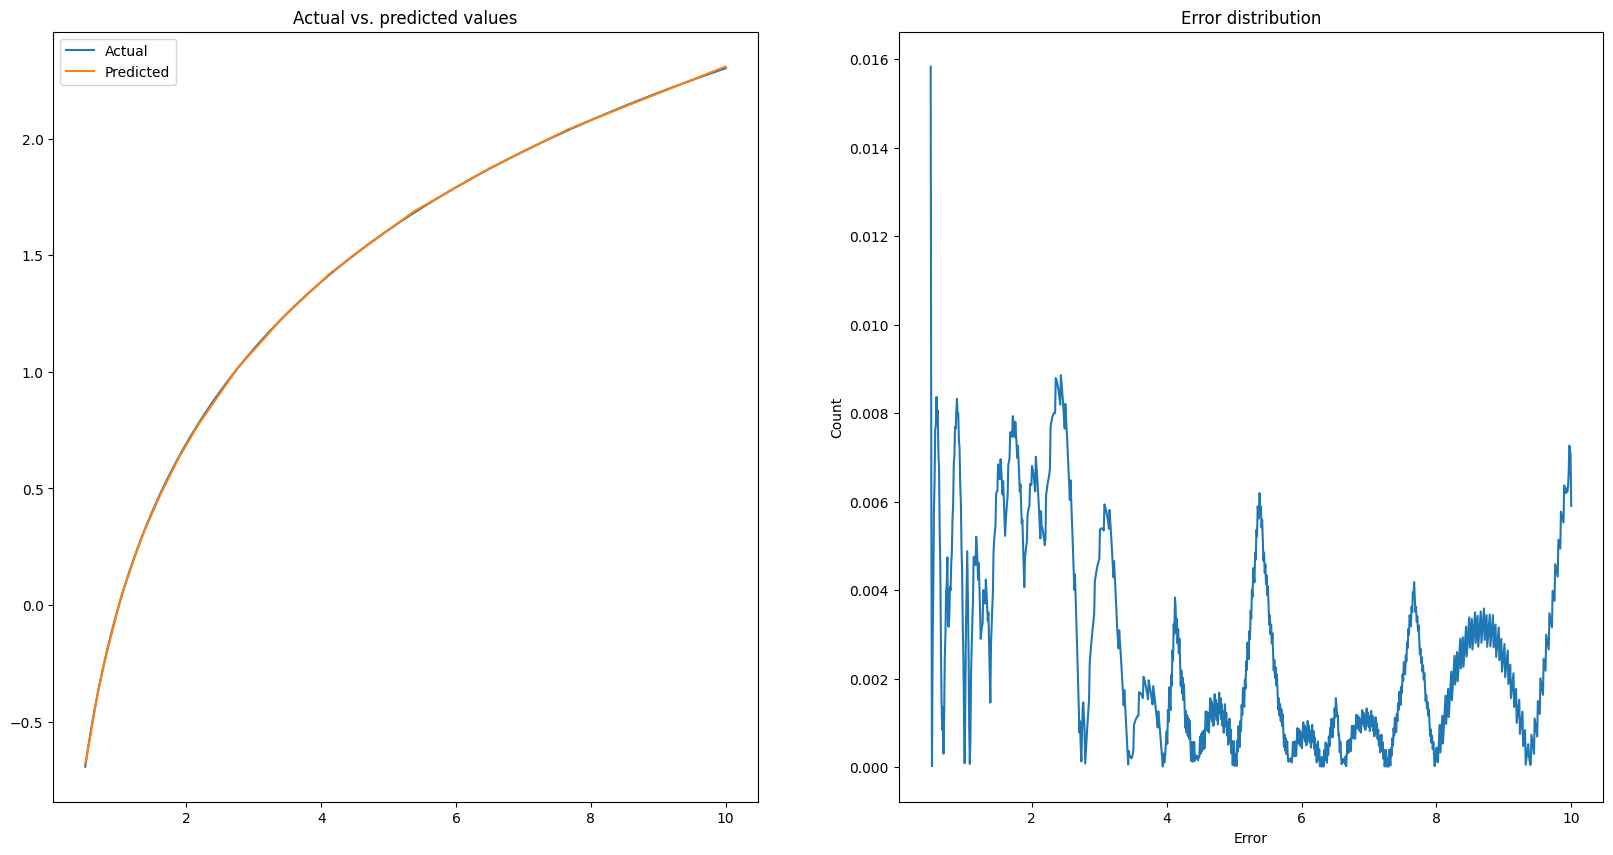

In [13]:
# Show the evaluation results
# with two subplots: one for the direct comparison of the predicted and the actual values
# and one for the error distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the predicted and the actual values
ax1.plot(x_test, y_test, label='Actual')
ax1.plot(x_test, model.predict(x_test), label='Predicted')
ax1.set_title('Actual vs. predicted values')
ax1.legend()

# Plot the error distribution
error = np.abs(model.predict(x_test).T - y_test)
ax2.plot(x_test, error.T, label='Error')
ax2.set_title('Error distribution')
ax2.set_xlabel('Error')
ax2.set_ylabel('Count')

plt.show()

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                64        
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)               

In [3]:
%load_ext tensorboard
%tensorboard --logdir logs

In [21]:
!kill 30058

/bin/bash: /home/jun2m/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
